# Multimodal Classifier (BERT + ResNet50) — MMHS150K Hate Speech Detection
## Google Colab Training Notebook

**Architecture — Late Fusion:**
- **Text branch**: `bert-base-uncased` → [CLS] (768) → Linear(768→512) → ReLU
- **Image branch**: ResNet50 (ImageNet) → GAP (2048) → Linear(2048→512) → ReLU
- **Fusion**: Concat [512 ‖ 512] → Dropout(0.4) → Linear(1024→2)

**Total parameters: ~134M** (BERT 110M + ResNet50 23M + fusion head)

### Before starting
1. **Enable GPU:** Runtime → Change runtime type → GPU (T4 free / A100 Colab Pro)
2. **Mount Drive:** Run Step 2 — checkpoints + results will be saved to your Drive
3. **Upload data:** Run Step 3 to upload `MMHS150K_GT.json`, split files, and image zip

---


## Step 1 — Check GPU & Install Libraries

In [1]:
# Remove broken versions
!pip uninstall -y pillow torchvision

# Install compatible versions for PyTorch 2.10
!pip install pillow==11.0.0 torchvision --no-cache-dir


Found existing installation: pillow 11.0.0
Uninstalling pillow-11.0.0:
  Successfully uninstalled pillow-11.0.0
Found existing installation: torchvision 0.25.0
Uninstalling torchvision-0.25.0:
  Successfully uninstalled torchvision-0.25.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 193.4 MB/s eta 0:00:00


In [1]:
# ── Confirm GPU is active ──────────────────────────────────────────────────
import torch, subprocess, platform

print(f"Python  : {platform.python_version()}")
print(f"PyTorch : {torch.__version__}")
print(f"CUDA    : {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU     : {torch.cuda.get_device_name(0)}")
    print(f"VRAM    : {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠️  No GPU detected.")
    print("Go to: Runtime → Change runtime type → GPU  (T4 is free)")

Python  : 3.12.12
PyTorch : 2.10.0+cu128
CUDA    : True
GPU     : NVIDIA L4
VRAM    : 23.7 GB


## Step 2 — Mount Google Drive
All checkpoints and results will be saved to your Drive so they persist after the session ends.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# ── Directory layout on Drive ──────────────────────────────────────────────
import os
DRIVE_ROOT = '/content/drive/MyDrive/MMHS150K_Multimodal'
os.makedirs(f'{DRIVE_ROOT}/checkpoints', exist_ok=True)
os.makedirs(f'{DRIVE_ROOT}/results',     exist_ok=True)

print(f"✅ Drive mounted. Saving to: {DRIVE_ROOT}")


Mounted at /content/drive
✅ Drive mounted. Saving to: /content/drive/MyDrive/MMHS150K_Multimodal


## Step 3 — Upload Dataset Files + Images
Upload from your local machine:
- `data/MMHS150K_GT.json`
- `data/splits/train_ids.txt`, `val_ids.txt`, `test_ids.txt`
- `img_resized.zip` — the resized image archive (skip if already extracted from the CNN notebook)

In [3]:
from google.colab import files
import os
import zipfile

# ── Text + label files ────────────────────────────────────────────────────
print("📁 Upload MMHS150K_GT.json  train_ids.txt  val_ids.txt  test_ids.txt")
uploaded = files.upload()

for fname, data in uploaded.items():
    with open(f'/content/{fname}', 'wb') as f:
        f.write(data)
    print(f"   Saved /content/{fname}  ({len(data)/1e6:.1f} MB)")


📁 Upload MMHS150K_GT.json  train_ids.txt  val_ids.txt  test_ids.txt


Saving train_ids.txt to train_ids.txt
Saving test_ids.txt to test_ids.txt
Saving val_ids.txt to val_ids.txt
Saving MMHS150K_GT.json to MMHS150K_GT.json
   Saved /content/train_ids.txt  (2.7 MB)
   Saved /content/test_ids.txt  (0.2 MB)
   Saved /content/val_ids.txt  (0.1 MB)
   Saved /content/MMHS150K_GT.json  (51.4 MB)


In [4]:
import zipfile, os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path to zip file in My Drive
ZIP_PATH = '/content/drive/MyDrive/img_resized.zip'   # adjust if inside a folder
IMG_DIR  = '/content/img_resized'

# Extract only if not already extracted
if not os.path.exists(IMG_DIR):
    print("Extracting images from Drive...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
        zf.extractall('/content/')
    print(f"Done — {len(os.listdir(IMG_DIR)):,} images")
else:
    print(f"Already extracted — {len(os.listdir(IMG_DIR)):,} images")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracting images from Drive...
Done — 150,000 images


## Step 4 — Training Configuration
Tune the hyperparameters here. The defaults are well-tested.

In [5]:
# ═══════════════════════════════════════════════════════════════════════════
#  CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════

# Paths
GT_FILE   = '/content/MMHS150K_GT.json'
TRAIN_IDS = '/content/train_ids.txt'
VAL_IDS   = '/content/val_ids.txt'
TEST_IDS  = '/content/test_ids.txt'
IMG_DIR   = '/content/img_resized'     # folder containing {tweet_id}.jpg files

# Model
BERT_NAME      = 'bert-base-uncased'
BINARY         = True   # True = binary (NotHate/Hate)  |  False = 6-class

# Tokenisation
MAX_LEN        = 96     # 96 covers 99% of tweets; increase to 128 if budget allows

# Training
EPOCHS         = 5
BATCH_SIZE     = 32     # ⚠️  multimodal is memory-heavy — use 32 on T4 (16 GB)
LR             = 2e-5   # BERT / ResNet backbone learning rate
HEAD_LR_MULT   = 5      # fusion-head LR multiplier  (head trains at LR × 5)
CNN_LR_MULT    = 0.1    # ResNet backbone gets LR × 0.1  (slower fine-tuning)
DROPOUT        = 0.4
PATIENCE       = 2      # early stopping patience
NUM_WORKERS    = 2

# Reproducibility
import numpy as np
import torch
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Label maps
TASK_TAG    = 'binary' if BINARY else '6class'
N_CLASSES   = 2 if BINARY else 6
LABEL_MAP_B = {0: 'NotHate', 1: 'Hate'}
LABEL_MAP_6 = {0: 'NotHate', 1: 'Racist', 2: 'Sexist',
               3: 'Homophobe', 4: 'Religion', 5: 'OtherHate'}
LABEL_MAP   = LABEL_MAP_B if BINARY else LABEL_MAP_6
LABEL_NAMES = [LABEL_MAP[i] for i in range(N_CLASSES)]

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("✅ Config set:")
print(f"   Model      : {BERT_NAME} + ResNet50")
print(f"   Task       : {'Binary' if BINARY else '6-Class'} | {N_CLASSES} classes")
print(f"   Epochs     : {EPOCHS}  |  Batch: {BATCH_SIZE}  |  LR: {LR}")
print(f"   Head LR    : {LR * HEAD_LR_MULT}  |  CNN LR: {LR * CNN_LR_MULT}")
print(f"   Max length : {MAX_LEN} tokens  |  Device: {DEVICE}")


✅ Config set:
   Model      : bert-base-uncased + ResNet50
   Task       : Binary | 2 classes
   Epochs     : 5  |  Batch: 32  |  LR: 2e-05
   Head LR    : 0.0001  |  CNN LR: 2.0000000000000003e-06
   Max length : 96 tokens  |  Device: cuda


## Step 5 — Dataset & DataLoaders
Builds the multimodal dataset — each sample requires **both** an image file and tweet text. Samples missing either are skipped.

In [6]:
# ── Imports ────────────────────────────────────────────────────────────────
import json
from collections import Counter
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from transformers import BertTokenizerFast

# Fix for Pillow ImportError: https://github.com/pytorch/vision/issues/8482
!pip install --upgrade Pillow

# ── Image transforms ───────────────────────────────────────────────────────
_MEAN = [0.485, 0.456, 0.406]; _STD = [0.229, 0.224, 0.225]
TRAIN_TF = transforms.Compose([
    transforms.Resize(256), transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    transforms.ToTensor(), transforms.Normalize(_MEAN, _STD),
])
EVAL_TF = transforms.Compose([
    transforms.Resize(256), transforms.CenterCrop(224),
    transforms.ToTensor(), transforms.Normalize(_MEAN, _STD),
])

# ── Helper functions ───────────────────────────────────────────────────────
def majority_vote(labels):
    return Counter(labels).most_common(1)[0][0]

def load_ids(path):
    with open(path) as f: return [l.strip() for l in f if l.strip()]


# ── Dataset class ──────────────────────────────────────────────────────────
class MMHS150KMultimodalDataset(Dataset):
    def __init__(self, ids, gt, img_dir, tokenizer, img_tf, max_len=96, binary=True):
        self.img_dir   = Path(img_dir)
        self.tokenizer = tokenizer
        self.img_tf    = img_tf
        self.max_len   = max_len
        self.binary    = binary
        self.samples   = []   # (text, img_path, label)
        self.skipped   = 0
        for tid in ids:
            item = gt.get(tid)
            if item is None: self.skipped += 1; continue
            text = str(item.get('tweet_text') or '').strip()
            if not text: self.skipped += 1; continue
            img_path = self.img_dir / f'{tid}.jpg'
            if not img_path.exists(): self.skipped += 1; continue
            labs = item.get('labels', [])
            if not (isinstance(labs, list) and len(labs) >= 1): self.skipped += 1; continue
            while len(labs) < 3: labs = labs + [labs[-1]]
            labs = [int(x) for x in labs[:3]]
            y6 = majority_vote(labs)
            y  = (0 if y6 == 0 else 1) if binary else y6
            self.samples.append((text, str(img_path), y))

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        text, img_path, y = self.samples[idx]
        enc = self.tokenizer(text, padding='max_length', truncation=True,
                             max_length=self.max_len, return_tensors='pt')
        text_data = {k: v.squeeze(0) for k, v in enc.items()}
        try:    img = Image.open(img_path).convert('RGB')
        except: img = Image.new('RGB', (224, 224), (0, 0, 0))
        return text_data, self.img_tf(img), torch.tensor(y, dtype=torch.long)

    def class_weights(self):
        counts = Counter(y for _, _, y in self.samples)
        total = len(self.samples)
        return torch.tensor([total / (N_CLASSES * counts.get(i, 1))
                              for i in range(N_CLASSES)], dtype=torch.float)

    def sample_weights(self):
        counts = Counter(y for _, _, y in self.samples)
        return [1.0 / counts[y] for _, _, y in self.samples]


def multimodal_collate(batch):
    text_list, img_list, label_list = zip(*batch)
    text_batch = {k: torch.stack([d[k] for d in text_list]) for k in text_list[0]}
    return text_batch, torch.stack(img_list), torch.stack(label_list)


# ── Load ground-truth labels ───────────────────────────────────────────────
print("Loading ground-truth labels...")
with open(GT_FILE, encoding='utf-8') as f: gt = json.load(f)
print(f"  Loaded {len(gt):,} entries from MMHS150K_GT.json")

# ── Tokenizer ──────────────────────────────────────────────────────────────
print(f"\nLoading tokenizer: {BERT_NAME}")
tokenizer = BertTokenizerFast.from_pretrained(BERT_NAME)

train_ids, val_ids, test_ids = load_ids(TRAIN_IDS), load_ids(VAL_IDS), load_ids(TEST_IDS)
print(f"  Split sizes  —  train: {len(train_ids):,}  val: {len(val_ids):,}  test: {len(test_ids):,}")

train_ds = MMHS150KMultimodalDataset(train_ids, gt, IMG_DIR, tokenizer, TRAIN_TF, MAX_LEN, BINARY)
val_ds   = MMHS150KMultimodalDataset(val_ids,   gt, IMG_DIR, tokenizer, EVAL_TF,  MAX_LEN, BINARY)
test_ds  = MMHS150KMultimodalDataset(test_ids,  gt, IMG_DIR, tokenizer, EVAL_TF,  MAX_LEN, BINARY)

print(f"\n  Train : {len(train_ds):,}  (skipped {train_ds.skipped})")
print(f"  Val   : {len(val_ds):,}  (skipped {val_ds.skipped})")
print(f"  Test  : {len(test_ds):,}  (skipped {test_ds.skipped})")

# Class distribution
counts = Counter(y for _, _, y in train_ds.samples)
print("\n  Train class distribution:")
for i in range(N_CLASSES):
    c = counts.get(i, 0)
    print(f"    {LABEL_NAMES[i]:<12}: {c:>7,}  ({c/len(train_ds)*100:5.1f}%)")

# ── DataLoaders ────────────────────────────────────────────────────────────
sampler      = WeightedRandomSampler(train_ds.sample_weights(), len(train_ds), replacement=True)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                          num_workers=NUM_WORKERS, collate_fn=multimodal_collate, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, collate_fn=multimodal_collate, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, collate_fn=multimodal_collate, pin_memory=True)

print(f"\n  Batches per epoch: {len(train_loader):,}")
print(f"  Class weights    : {train_ds.class_weights().tolist()}")
print("✅ DataLoaders ready.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 80.2 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: pillow 11.0.0
    Uninstalling pillow-11.0.0:
      Successfully uninstalled pillow-11.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 5.50.0 requires pillow<12.0,>=8.0, but you have pillow 12.1.1 which is incompatible.
Loading ground-truth labels...
  Loaded 149,823 entries from MMHS150K_GT.json

Loading tokenizer: bert-base-uncased


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

  Split sizes  —  train: 134,823  val: 5,000  test: 10,000

  Train : 134,823  (skipped 0)
  Val   : 5,000  (skipped 0)
  Test  : 10,000  (skipped 0)

  Train class distribution:
    NotHate     : 108,460  ( 80.4%)
    Hate        :  26,363  ( 19.6%)

  Batches per epoch: 4,214
  Class weights    : [0.6215332746505737, 2.5570497512817383]
✅ DataLoaders ready.


## Step 6 — Model Definition
Defines `MultimodalClassifier`: a late-fusion network combining the BERT [CLS] text embedding and ResNet50 image features via learned projection heads.

In [7]:
import torch.nn as nn
from torchvision import models
from transformers import BertModel, get_linear_schedule_with_warmup


# ── Model class ────────────────────────────────────────────────────────────
class MultimodalClassifier(nn.Module):
    """BERT [CLS] + ResNet50 → late fusion → Linear classifier."""
    PROJ_DIM = 512

    def __init__(self, num_classes=2, bert_name='bert-base-uncased', dropout=0.4):
        super().__init__()
        # Text branch
        self.bert      = BertModel.from_pretrained(bert_name)
        self.text_proj = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, self.PROJ_DIM), nn.ReLU())
        # Image branch
        backbone    = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        in_feat     = backbone.fc.in_features
        backbone.fc = nn.Identity()
        self.resnet   = backbone
        self.img_proj = nn.Sequential(nn.Linear(in_feat, self.PROJ_DIM), nn.ReLU())
        # Fusion head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout), nn.Linear(self.PROJ_DIM * 2, num_classes))

    def forward(self, input_ids, attention_mask, pixel_values, token_type_ids=None):
        txt = self.text_proj(
            self.bert(input_ids=input_ids, attention_mask=attention_mask,
                      token_type_ids=token_type_ids).pooler_output)  # (B, 512)
        img = self.img_proj(self.resnet(pixel_values))               # (B, 512)
        return self.classifier(torch.cat([txt, img], dim=1))         # (B, num_classes)


# ── Build model ────────────────────────────────────────────────────────────
model   = MultimodalClassifier(num_classes=N_CLASSES, bert_name=BERT_NAME, dropout=DROPOUT).to(DEVICE)
cw      = train_ds.class_weights().to(DEVICE)
loss_fn = nn.CrossEntropyLoss(weight=cw)

total_params = sum(p.numel() for p in model.parameters())
trainable    = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"✅ Model loaded: BERT ({BERT_NAME}) + ResNet50")
print(f"   Total params    : {total_params:,}")
print(f"   Trainable params: {trainable:,}")

# ── Optimizer with differential learning rates ─────────────────────────────
# Backbone layers train slower; new projection / fusion heads train faster
optimizer = torch.optim.AdamW([
    {'params': model.bert.parameters(),       'lr': LR},
    {'params': model.resnet.parameters(),     'lr': LR * CNN_LR_MULT},
    {'params': model.text_proj.parameters(),  'lr': LR * HEAD_LR_MULT},
    {'params': model.img_proj.parameters(),   'lr': LR * HEAD_LR_MULT},
    {'params': model.classifier.parameters(), 'lr': LR * HEAD_LR_MULT},
], weight_decay=1e-4)

total_steps  = len(train_loader) * EPOCHS
warmup_steps = int(total_steps * 0.1)
scheduler    = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)

print(f"\n   Class weights: {cw.cpu().tolist()}")
print(f"   Total steps  : {total_steps:,}  |  Warmup: {warmup_steps:,}")


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s]


✅ Model loaded: BERT (bert-base-uncased) + ResNet50
   Total params    : 134,435,138
   Trainable params: 134,435,138

   Class weights: [0.6215332746505737, 2.5570497512817383]
   Total steps  : 21,070  |  Warmup: 2,107


## Step 7 — Training & Evaluation Loops
Runs the full training loop with early stopping on validation Macro-F1. Best checkpoint is saved to Drive each epoch a new best is achieved.

In [8]:
import time
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score


# ── Evaluation helper ──────────────────────────────────────────────────────
@torch.no_grad()
def evaluate(loader):
    model.eval()
    preds_all, labels_all, total_loss = [], [], 0.0
    for text_batch, imgs, labels in loader:
        labels     = labels.to(DEVICE); imgs = imgs.to(DEVICE)
        text_batch = {k: v.to(DEVICE) for k, v in text_batch.items()}
        logits = model(input_ids=text_batch['input_ids'],
                       attention_mask=text_batch['attention_mask'],
                       pixel_values=imgs,
                       token_type_ids=text_batch.get('token_type_ids'))
        total_loss += loss_fn(logits, labels).item()
        preds_all.extend(torch.argmax(logits, 1).cpu().tolist())
        labels_all.extend(labels.cpu().tolist())
    avg_loss = total_loss / max(1, len(loader))
    acc      = accuracy_score(labels_all, preds_all)
    f1_mac   = f1_score(labels_all, preds_all, average='macro', zero_division=0)
    return avg_loss, acc, f1_mac, labels_all, preds_all


# ── Full training loop with early stopping + Drive checkpointing ───────────
BEST_CKPT   = f'{DRIVE_ROOT}/checkpoints/multimodal_{TASK_TAG}_best.pt'
history     = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
best_val_f1 = -1.0
no_improve  = 0

print(f"{'='*65}")
print(f"  Starting training — {EPOCHS} epochs on {DEVICE}")
print(f"{'='*65}\n")
t0_total = time.time()

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss, n_correct, n_total = 0.0, 0, 0
    t0 = time.time()

    pbar = tqdm(train_loader, desc=f'Epoch {epoch}/{EPOCHS}', leave=True)
    for step, (text_batch, imgs, labels) in enumerate(pbar, 1):
        labels     = labels.to(DEVICE); imgs = imgs.to(DEVICE)
        text_batch = {k: v.to(DEVICE) for k, v in text_batch.items()}

        optimizer.zero_grad()
        logits = model(input_ids=text_batch['input_ids'],
                       attention_mask=text_batch['attention_mask'],
                       pixel_values=imgs,
                       token_type_ids=text_batch.get('token_type_ids'))
        loss = loss_fn(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step(); scheduler.step()

        running_loss += loss.item()
        preds     = torch.argmax(logits, 1)
        n_correct += (preds == labels).sum().item()
        n_total   += labels.size(0)
        pbar.set_postfix(loss=f'{running_loss/step:.4f}', acc=f'{n_correct/n_total:.4f}')

    train_loss = running_loss / len(train_loader)
    train_acc  = n_correct / n_total
    val_loss, val_acc, val_f1, _, _ = evaluate(val_loader)

    history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss);     history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    elapsed = time.time() - t0
    print(f"\n  Epoch {epoch}/{EPOCHS}  [{elapsed:.0f}s]")
    print(f"    train_loss={train_loss:.4f}  train_acc={train_acc:.4f}")
    print(f"    val_loss  ={val_loss:.4f}  val_acc  ={val_acc:.4f}  val_f1={val_f1:.4f}")

    # ── Save best checkpoint to Drive ─────────────────────────────────────
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1; no_improve = 0
        torch.save({'epoch': epoch, 'model_state': model.state_dict(),
                    'val_f1': val_f1,
                    'config': {'num_classes': N_CLASSES, 'dropout': DROPOUT,
                               'bert_name': BERT_NAME, 'binary': BINARY, 'task': TASK_TAG}},
                   BEST_CKPT)
        print(f"    ✅ Best model saved to Drive  (val_f1={best_val_f1:.4f})")
    else:
        no_improve += 1
        print(f"    ⏳ No improvement ({no_improve}/{PATIENCE})")
        if no_improve >= PATIENCE:
            print(f"\n  ⛔ Early stopping triggered after epoch {epoch}.")
            break

total_time = time.time() - t0_total
print(f"\n  Total training time: {total_time/60:.1f} min")
print(f"  Best val Macro-F1 : {best_val_f1:.4f}")
print(f"  Checkpoint saved to: {BEST_CKPT}")


  Starting training — 5 epochs on cuda



Epoch 1/5:   0%|          | 0/4214 [00:00<?, ?it/s]


  Epoch 1/5  [1604s]
    train_loss=0.4554  train_acc=0.5228
    val_loss  =0.8195  val_acc  =0.4760  val_f1=0.3733
    ✅ Best model saved to Drive  (val_f1=0.3733)


Epoch 2/5:   0%|          | 0/4214 [00:00<?, ?it/s]


  Epoch 2/5  [1604s]
    train_loss=0.3880  train_acc=0.6643
    val_loss  =0.7920  val_acc  =0.5822  val_f1=0.5769
    ✅ Best model saved to Drive  (val_f1=0.5769)


Epoch 3/5:   0%|          | 0/4214 [00:00<?, ?it/s]


  Epoch 3/5  [1604s]
    train_loss=0.3015  train_acc=0.7957
    val_loss  =0.9433  val_acc  =0.6174  val_f1=0.6171
    ✅ Best model saved to Drive  (val_f1=0.6171)


Epoch 4/5:   0%|          | 0/4214 [00:00<?, ?it/s]


  Epoch 4/5  [1604s]
    train_loss=0.2332  train_acc=0.8548
    val_loss  =1.0560  val_acc  =0.6444  val_f1=0.6396
    ✅ Best model saved to Drive  (val_f1=0.6396)


Epoch 5/5:   0%|          | 0/4214 [00:00<?, ?it/s]


  Epoch 5/5  [1603s]
    train_loss=0.1931  train_acc=0.8833
    val_loss  =1.2162  val_acc  =0.6534  val_f1=0.6468
    ✅ Best model saved to Drive  (val_f1=0.6468)

  Total training time: 133.7 min
  Best val Macro-F1 : 0.6468
  Checkpoint saved to: /content/drive/MyDrive/MMHS150K_Multimodal/checkpoints/multimodal_binary_best.pt


## Step 8 — Training Curves

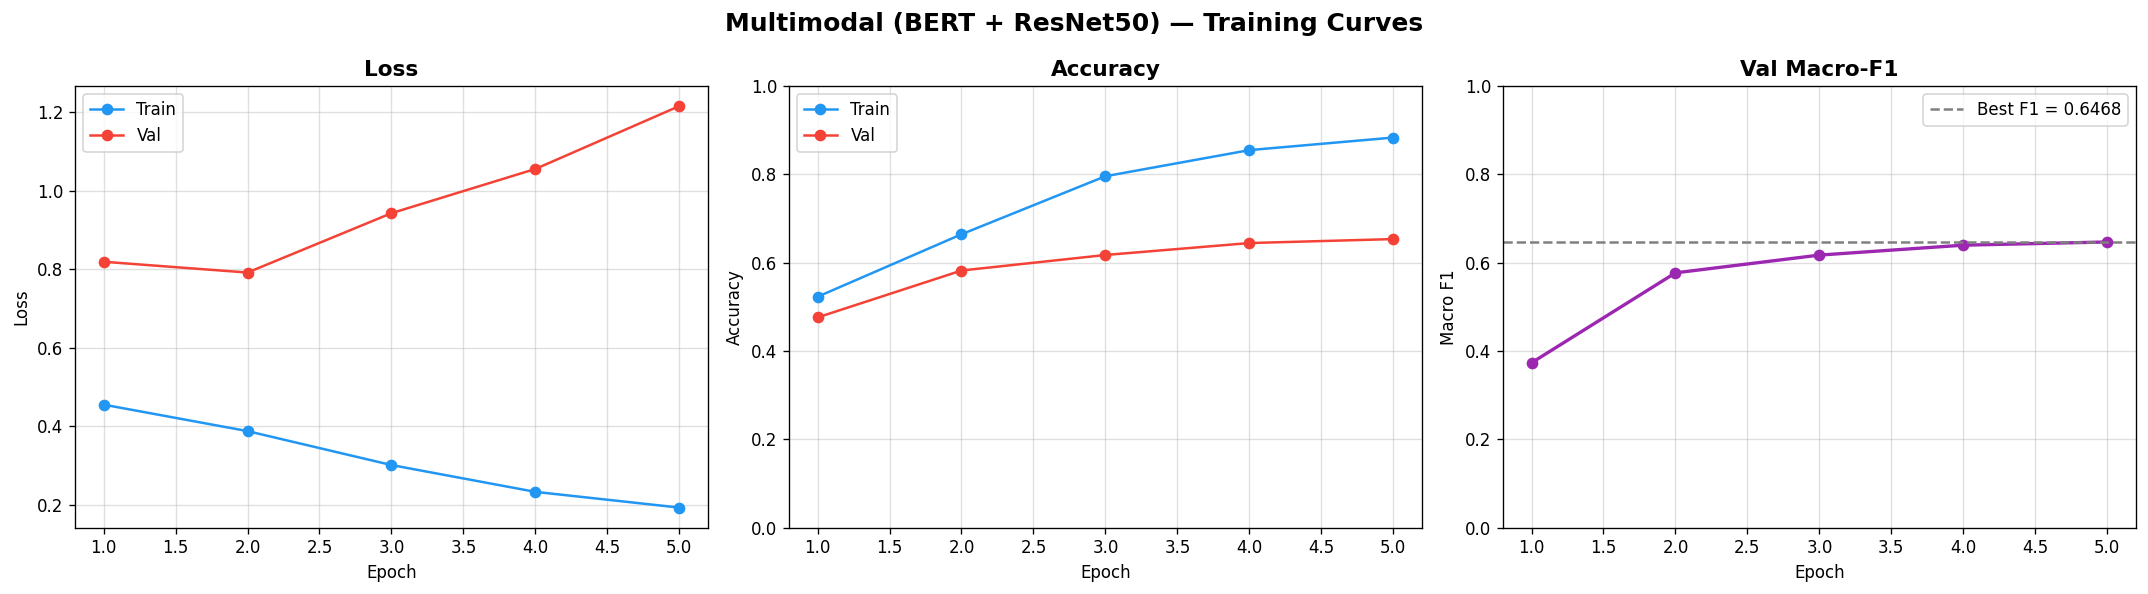

✅ Saved → /content/drive/MyDrive/MMHS150K_Multimodal/results/training_curves.png


In [9]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120

epochs_ran = range(1, len(history['train_loss']) + 1)
fig, axes  = plt.subplots(1, 3, figsize=(18, 5))

# ── Loss ───────────────────────────────────────────────────────────────────
axes[0].plot(epochs_ran, history['train_loss'], 'o-', color='#2196F3', label='Train')
axes[0].plot(epochs_ran, history['val_loss'],   'o-', color='#F44336', label='Val')
axes[0].set_title('Loss', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss')
axes[0].legend(); axes[0].grid(True, alpha=0.4)

# ── Accuracy ───────────────────────────────────────────────────────────────
axes[1].plot(epochs_ran, history['train_acc'], 'o-', color='#2196F3', label='Train')
axes[1].plot(epochs_ran, history['val_acc'],   'o-', color='#F44336', label='Val')
axes[1].set_title('Accuracy', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0, 1); axes[1].legend(); axes[1].grid(True, alpha=0.4)

# ── Val Macro-F1 ───────────────────────────────────────────────────────────
axes[2].plot(epochs_ran, history['val_f1'], 'o-', color='#9C27B0', linewidth=2)
axes[2].axhline(max(history['val_f1']), color='gray', linestyle='--',
                label=f"Best F1 = {max(history['val_f1']):.4f}")
axes[2].set_title('Val Macro-F1', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Epoch'); axes[2].set_ylabel('Macro F1')
axes[2].set_ylim(0, 1); axes[2].legend(); axes[2].grid(True, alpha=0.4)

plt.suptitle('Multimodal (BERT + ResNet50) — Training Curves', fontsize=15, fontweight='bold')
plt.tight_layout()

CURVES_PATH = f'{DRIVE_ROOT}/results/training_curves.png'
plt.savefig(CURVES_PATH, dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Saved → {CURVES_PATH}")


## Step 9 — Evaluate Best Model on Test Set

In [10]:
import json as json_mod
from sklearn.metrics import classification_report, confusion_matrix

# ── Load best checkpoint ───────────────────────────────────────────────────
print(f"Loading best checkpoint from {BEST_CKPT} ...")
ckpt = torch.load(BEST_CKPT, map_location=DEVICE)
model.load_state_dict(ckpt['model_state'])
print(f"  Best epoch: {ckpt['epoch']}  |  val_f1: {ckpt['val_f1']:.4f}")

# ── Test evaluation ────────────────────────────────────────────────────────
test_loss, test_acc, test_f1, y_true, y_pred = evaluate(test_loader)

report_str  = classification_report(y_true, y_pred, target_names=LABEL_NAMES,
                                    digits=4, zero_division=0)
report_dict = classification_report(y_true, y_pred, target_names=LABEL_NAMES,
                                    digits=4, zero_division=0, output_dict=True)
cm          = confusion_matrix(y_true, y_pred, labels=list(range(N_CLASSES)))

print("\n" + "="*65)
print("  TEST RESULTS")
print("="*65)
print(f"  Loss     : {test_loss:.4f}")
print(f"  Accuracy : {test_acc:.4f}")
print(f"  Macro F1 : {test_f1:.4f}")
print("\n" + report_str)
print("Confusion matrix:\n", cm)

# ── Save metrics JSON to Drive ─────────────────────────────────────────────
metrics = {
    'task': TASK_TAG, 'model': 'multimodal_bert_resnet50',
    'epochs_ran': len(history['train_loss']),
    'best_epoch': int(ckpt['epoch']), 'best_val_f1': float(ckpt['val_f1']),
    'history': history,
    'test': {
        'loss': test_loss, 'accuracy': test_acc, 'macro_f1': test_f1,
        'per_class': {
            lbl: {
                'precision': report_dict.get(lbl, {}).get('precision', 0),
                'recall':    report_dict.get(lbl, {}).get('recall',    0),
                'f1':        report_dict.get(lbl, {}).get('f1-score',  0),
                'support':   report_dict.get(lbl, {}).get('support',   0),
            } for lbl in LABEL_NAMES
        },
    },
}
METRICS_PATH = f'{DRIVE_ROOT}/results/metrics.json'
with open(METRICS_PATH, 'w') as f: json_mod.dump(metrics, f, indent=2)
print(f"✅ Metrics saved → {METRICS_PATH}")

# ── Save classification report text ───────────────────────────────────────
REPORT_PATH = f'{DRIVE_ROOT}/results/classification_report.txt'
with open(REPORT_PATH, 'w') as f:
    f.write(f"Multimodal (BERT + ResNet50) — {TASK_TAG}\n")
    f.write(f"Best epoch: {ckpt['epoch']} | val_f1: {ckpt['val_f1']:.4f}\n\n")
    f.write(report_str)
    f.write(f"\n\nConfusion Matrix:\n{cm}\n")
print(f"✅ Report saved  → {REPORT_PATH}")


Loading best checkpoint from /content/drive/MyDrive/MMHS150K_Multimodal/checkpoints/multimodal_binary_best.pt ...
  Best epoch: 5  |  val_f1: 0.6468

  TEST RESULTS
  Loss     : 1.2214
  Accuracy : 0.6448
  Macro F1 : 0.6383

              precision    recall  f1-score   support

     NotHate     0.6753    0.6988    0.6868      5574
        Hate     0.6033    0.5768    0.5897      4426

    accuracy                         0.6448     10000
   macro avg     0.6393    0.6378    0.6383     10000
weighted avg     0.6434    0.6448    0.6439     10000

Confusion matrix:
 [[3895 1679]
 [1873 2553]]
✅ Metrics saved → /content/drive/MyDrive/MMHS150K_Multimodal/results/metrics.json
✅ Report saved  → /content/drive/MyDrive/MMHS150K_Multimodal/results/classification_report.txt


## Step 10 — Visualise Test Results

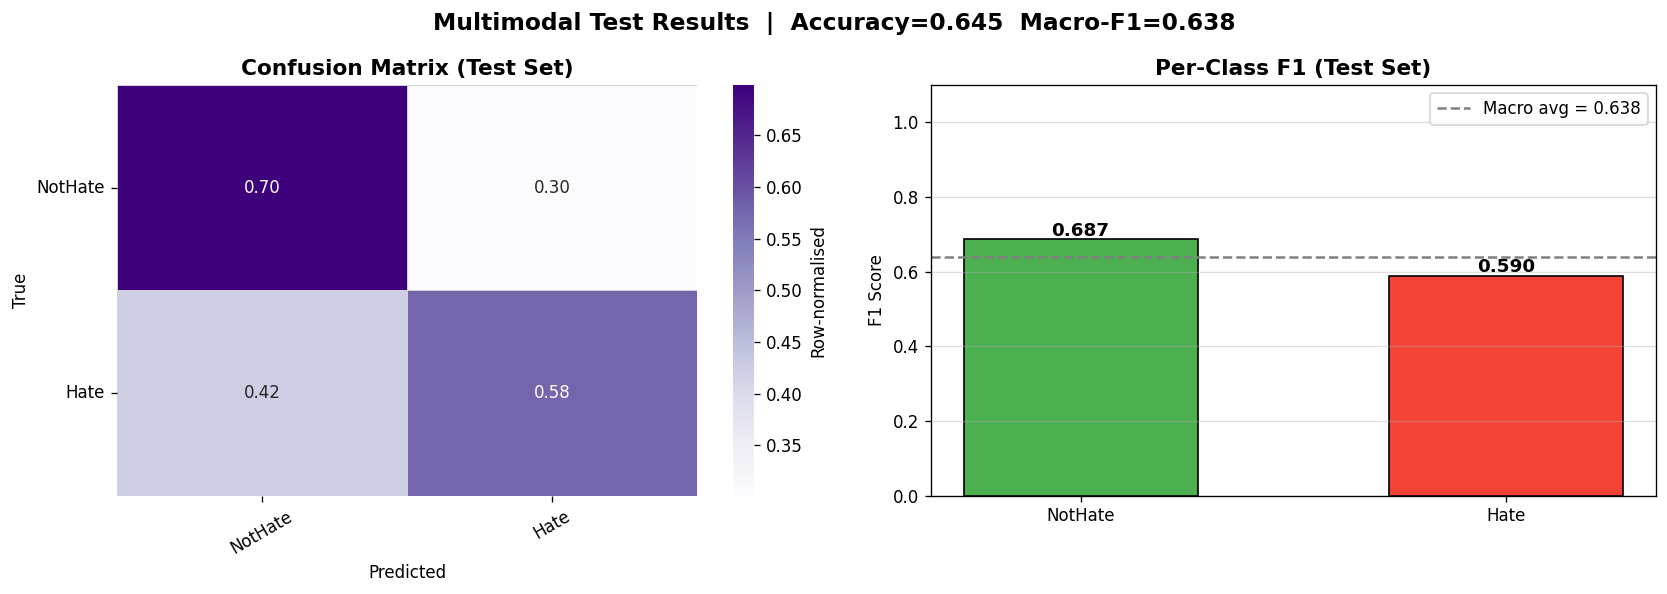

✅ Saved → /content/drive/MyDrive/MMHS150K_Multimodal/results/confusion_matrix.png


In [11]:
import seaborn as sns
import numpy as np

COLORS    = ['#4CAF50', '#F44336', '#FF9800', '#9C27B0', '#2196F3', '#FF5722'][:N_CLASSES]
f1_scores = [report_dict.get(cls, {}).get('f1-score', 0.0) for cls in LABEL_NAMES]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ── (A) Confusion matrix ───────────────────────────────────────────────────
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Purples',
            xticklabels=LABEL_NAMES, yticklabels=LABEL_NAMES,
            linewidths=0.5, linecolor='lightgray', ax=axes[0],
            cbar_kws={'label': 'Row-normalised'})
axes[0].set_title('Confusion Matrix (Test Set)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')
axes[0].tick_params(axis='x', rotation=30); axes[0].tick_params(axis='y', rotation=0)

# ── (B) Per-class F1 ──────────────────────────────────────────────────────
bars = axes[1].bar(LABEL_NAMES, f1_scores, color=COLORS, edgecolor='black', width=0.55)
for bar, val in zip(bars, f1_scores):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f'{val:.3f}', ha='center', fontsize=11, fontweight='bold')
axes[1].axhline(np.mean(f1_scores), color='gray', linestyle='--',
                label=f'Macro avg = {np.mean(f1_scores):.3f}')
axes[1].set_title('Per-Class F1 (Test Set)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('F1 Score'); axes[1].set_ylim(0, 1.1)
axes[1].legend(); axes[1].grid(axis='y', alpha=0.4)

plt.suptitle(f"Multimodal Test Results  |  Accuracy={test_acc:.3f}  Macro-F1={test_f1:.3f}",
             fontsize=14, fontweight='bold')
plt.tight_layout()

CM_PATH = f'{DRIVE_ROOT}/results/confusion_matrix.png'
plt.savefig(CM_PATH, dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Saved → {CM_PATH}")


## Step 11 — Save Full Model to Google Drive
Saves the complete PyTorch model state dict plus all config metadata — so you can reload and run inference without retraining.

In [12]:
# ── Save full classifier state dict + metadata ─────────────────────────────
FULL_SAVE_PATH = f'{DRIVE_ROOT}/checkpoints/multimodal_full_classifier.pt'

torch.save({
    'model_state':   model.state_dict(),
    'best_val_f1':   best_val_f1,
    'test_accuracy': test_acc,
    'test_macro_f1': test_f1,
    'history':       history,
    'config': {
        'num_classes': N_CLASSES, 'dropout': DROPOUT,
        'bert_name':   BERT_NAME, 'binary': BINARY,
        'task':        TASK_TAG,  'label_names': LABEL_NAMES,
        'architecture': 'bert_resnet50_late_fusion',
        'proj_dim': 512,
    },
}, FULL_SAVE_PATH)
print(f"✅ Full model classifier saved → {FULL_SAVE_PATH}")

# ── Summary of everything saved to Drive ──────────────────────────────────
print("\n📁 Files saved to Google Drive:")
for root_sub in ['results', 'checkpoints']:
    for fname in sorted(os.listdir(f'{DRIVE_ROOT}/{root_sub}')):
        size = os.path.getsize(f'{DRIVE_ROOT}/{root_sub}/{fname}')
        print(f"   {root_sub}/{fname}  ({size/1e6:.1f} MB)")


✅ Full model classifier saved → /content/drive/MyDrive/MMHS150K_Multimodal/checkpoints/multimodal_full_classifier.pt

📁 Files saved to Google Drive:
   results/classification_report.txt  (0.0 MB)
   results/confusion_matrix.png  (0.1 MB)
   results/metrics.json  (0.0 MB)
   results/training_curves.png  (0.1 MB)
   checkpoints/multimodal_binary_best.pt  (538.2 MB)
   checkpoints/multimodal_full_classifier.pt  (538.2 MB)


## Step 12 — Verify Saved Model (Quick Inference Test)
Reloads the model from Drive and runs a few test-set samples to confirm everything was saved correctly.

In [13]:
# ── Reload model from Drive checkpoint ────────────────────────────────────
saved = torch.load(FULL_SAVE_PATH, map_location=DEVICE)
cfg   = saved['config']

infer_model = MultimodalClassifier(
    num_classes=cfg['num_classes'], bert_name=cfg['bert_name'], dropout=cfg['dropout']
).to(DEVICE)
infer_model.load_state_dict(saved['model_state'])
infer_model.eval()

print("✅ Model reloaded successfully from Drive\n")
print(f"   Architecture : {cfg['architecture']}")
print(f"   Task         : {cfg['task']}  |  classes: {cfg['label_names']}")
print(f"   Saved test accuracy : {saved['test_accuracy']:.4f}")
print(f"   Saved test macro-F1 : {saved['test_macro_f1']:.4f}\n")

# ── Sample predictions on test-set items ──────────────────────────────────
print(f"{'Sample':<52}  {'True':>10}  {'Pred':>10}  {'Match':>6}")
print('-' * 84)
with torch.no_grad():
    for i in range(min(5, len(test_ds))):
        text, img_path, true_label = test_ds.samples[i]
        enc = tokenizer(text, padding='max_length', truncation=True,
                        max_length=MAX_LEN, return_tensors='pt')
        input_ids      = enc['input_ids'].to(DEVICE)
        attention_mask = enc['attention_mask'].to(DEVICE)
        try:    img = Image.open(img_path).convert('RGB')
        except: img = Image.new('RGB', (224, 224))
        pixel_values = EVAL_TF(img).unsqueeze(0).to(DEVICE)

        logits = infer_model(input_ids=input_ids, attention_mask=attention_mask,
                             pixel_values=pixel_values)
        pred    = torch.argmax(logits, 1).item()
        match   = '✓' if pred == true_label else '✗'
        preview = (text[:48] + '..') if len(text) > 50 else text
        print(f"{preview:<52}  {LABEL_NAMES[true_label]:>10}  {LABEL_NAMES[pred]:>10}  {match:>6}")

print("\n✅ All done! Your multimodal model is trained and saved.")


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✅ Model reloaded successfully from Drive

   Architecture : bert_resnet50_late_fusion
   Task         : binary  |  classes: ['NotHate', 'Hate']
   Saved test accuracy : 0.6448
   Saved test macro-F1 : 0.6383

Sample                                                      True        Pred   Match
------------------------------------------------------------------------------------
@RealCandaceO @RepJerryNadler @tedlieu You’re a ..          Hate        Hate       ✓
@ananavarro I have a conservative victim card; i..          Hate     NotHate       ✗
@HB_Aquarius @KhyMcflyyy I know this ain’t the n..          Hate     NotHate       ✗
@hoshijoon Oh no sis she pulled the mf race card..          Hate     NotHate       ✗
Look! More proof that I wasn’t always a mouthy t..       NotHate     NotHate       ✓

✅ All done! Your multimodal model is trained and saved.
